# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Importing the packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Check the data</a>  
    - <a href='#4.1'>Glimpse the data</a>  
    - <a href='#4.2'>Check missing data</a>
    - <a href='#4.3'>Check data imbalance</a>
- <a href='#5'>Data exploration</a>
    - <a href='#5.1'>Transactions in time</a>
    - <a href='#5.2'>Features correlation</a>
    - <a href='#5.3'>Features density plot</a>
- <a href='#6'>Model Selection</a>  
    - <a href='#6.1'>Metrics</a> 
    - <a href='#6.2'>Normal data </a> 
    - <a href='#6.3'>UnderSampled data </a> 
    - <a href='#6.4'>RandomForrestClassifier</a> 
        - <a href='#6.4a'>Prepare the model for Normal data</a>  
        - <a href='#6.4b'>Prepare the model for UnderSampled data</a> 
    - <a href='#6.5'>AdaBoostClassifier</a> 
        - <a href='#6.5a'>Prepare the model for Normal data</a>  
        - <a href='#6.5b'>Prepare the model for UnderSampled data</a>   
    - <a href='#6.6'>CatBoostClassifier</a> 
        - <a href='#6.6a'>Prepare the model for Normal data</a>  
        - <a href='#6.6b'>Prepare the model for UnderSampled data</a> 
- <a href='#7'>Viewing the final result</a>
- <a href='#8'>Model Summary</a>
- <a href='#9'>Creating a pickle file</a>
- <a href='#10'>Conclusion</a>
- <a href='#11'>References</a>

# <a id="1">Introduction</a>  

The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492 frauds** out of **284,807 transactions**. The dataset is **highly unbalanced**, the **positive class (frauds)** account for **0.172%** of all transactions.  

It contains only numerical input variables which are the result of a **PCA transformation**.   

Due to confidentiality issues, there are not provided the original features and more background information about the data.  

* Features **V1**, **V2**, ... **V28** are the **principal components** obtained with **PCA**;  
* The only features which have not been transformed with PCA are **Time** and **Amount**. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.   
* Feature **Class** is the response variable and it takes value **1** in case of fraud and **0** otherwise.  



# <a id="2"> Importing the packages</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import warnings
import pickle


C:\Users\Asus\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Standard Declarations

In [2]:
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

RFC_METRIC = 'gini' # Metric used for RandomForestClassifier.
                    # Gini also known as Gini impurity, calculates the amount of probability of a specific feature that is classified incorrectly when selected randomly
NUM_ESTIMATORS = 100 # number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/TEST SPLIT
TEST_SIZE = 0.20 # test size using_train_test_split

RANDOM_STATE = 2024

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# Specify the Plotly JavaScript library download URL
download_url = "https://cdn.plot.ly/plotly-latest.min.js"

# Download the Plotly JavaScript library (if not already downloaded)
download_plotlyjs(download_url)

# <a id="3">Read the data</a>

In [3]:
data_df = pd.read_csv("../inputs/creditcard.csv")

# <a id='4'>Check the data</a>

In [4]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


## <a id='4.1'>Glimpse the data</a> 
Seeing the data features (first 5 rows)

In [5]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's look into more details of the data

In [6]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.759061e-12,-8.251130e-13,-9.654937e-13,8.321385e-13,1.649999e-13,4.248366e-13,-3.054600e-13,8.777971e-14,-1.179749e-12,7.092545e-13,1.874948e-12,1.053347e-12,7.127611e-13,-1.474791e-13,-5.231558e-13,-2.282250e-13,-6.425436e-13,4.950748e-13,7.057397e-13,1.766111e-12,-3.405756e-13,-5.723197e-13,-9.725856e-13,1.464150e-12,-6.987102e-13,-5.617874e-13,3.332082e-12,-3.518874e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Looking into to the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

## <a id='4.2'>Check missing data</a>
Let's check if there is any missing data.

In [8]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum() / data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

##  <a id='4.3'>Check data imbalance</a>
Let's check data unbalance with respect with target value, i.e. Class

In [9]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Brown"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class**.

# <a id='5'>Data exploration</a>
##  <a id='5.1'>Transactions in time</a>

In [10]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"] # Not a fraud transaction
class_1 = data_df.loc[data_df['Class'] == 1]["Time"] # Fraud transaction

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [11]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


In [12]:
def CustomPlot(title, y_value):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
    s = sns.lineplot(ax = ax1, x="Hour", y=y_value, data=df.loc[df.Class==0])
    s = sns.lineplot(ax = ax2, x="Hour", y=y_value, data=df.loc[df.Class==1], color="red")
    plt.suptitle(title)
    plt.show();

### Total Amount

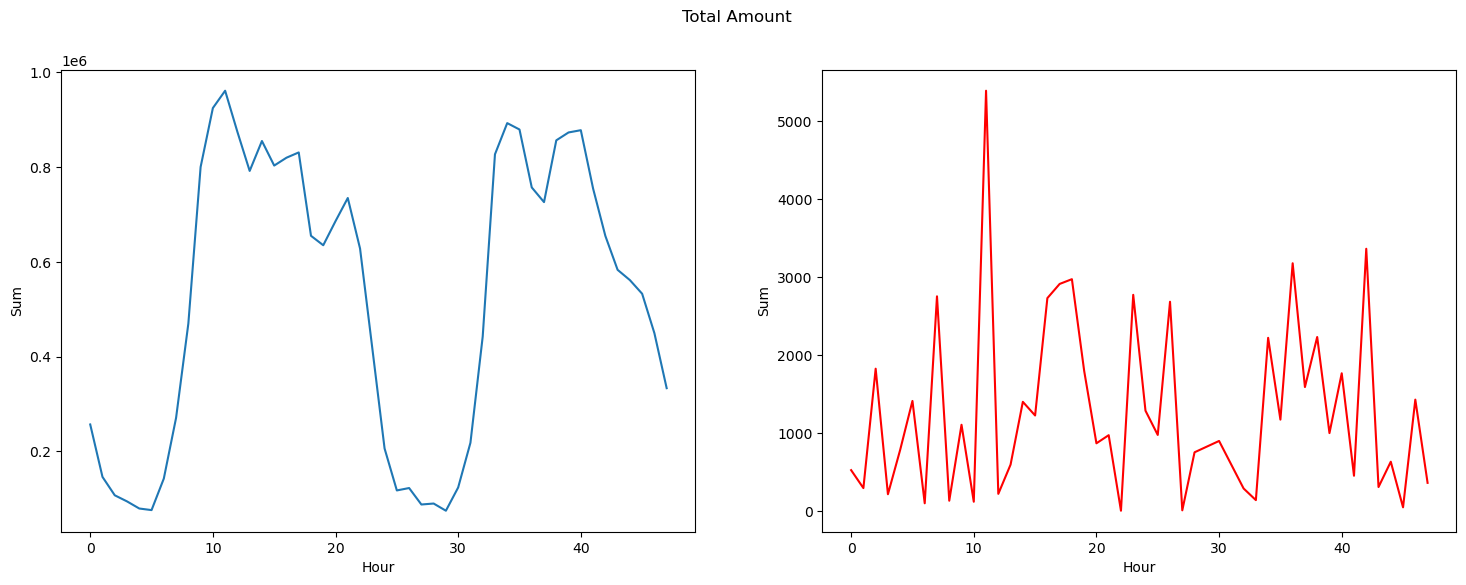

In [13]:
CustomPlot("Total Amount", "Sum")

### Total Number of Transactions

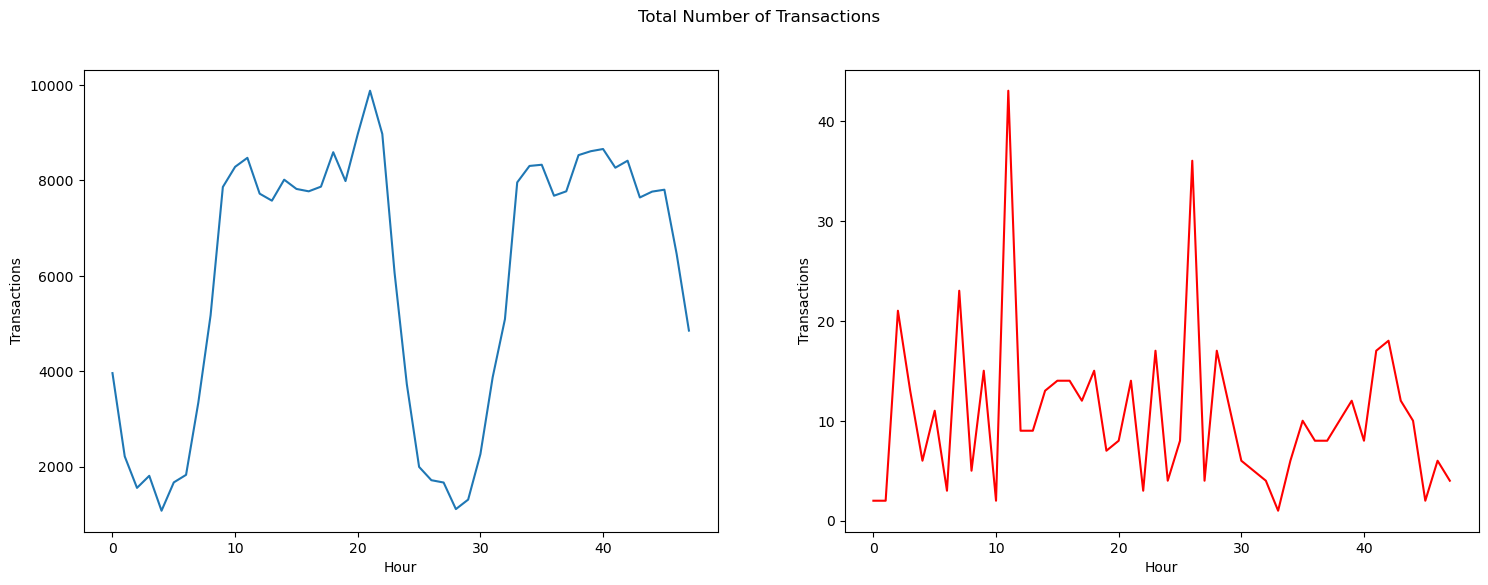

In [14]:
CustomPlot("Total Number of Transactions", "Transactions")

### Average Amount of Transactions

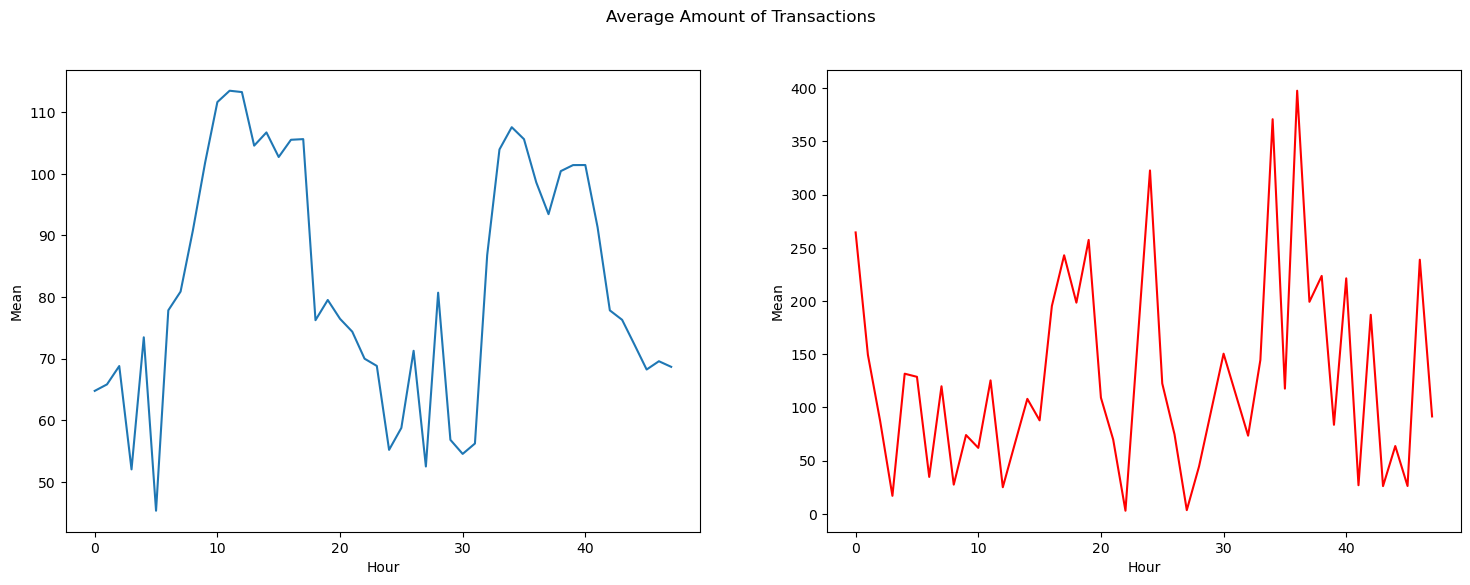

In [15]:
CustomPlot("Average Amount of Transactions", "Mean")

### Maximum Amount of Transactions

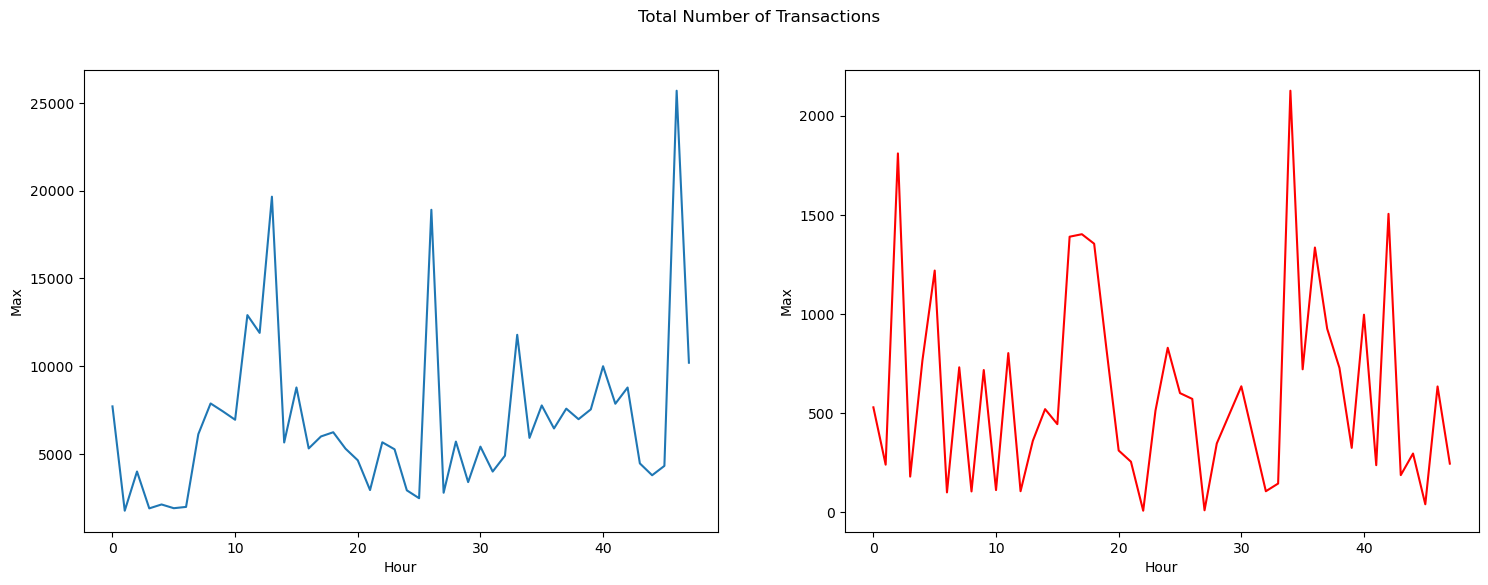

In [16]:
CustomPlot("Total Number of Transactions", "Max")

### Median Amount of Transactions

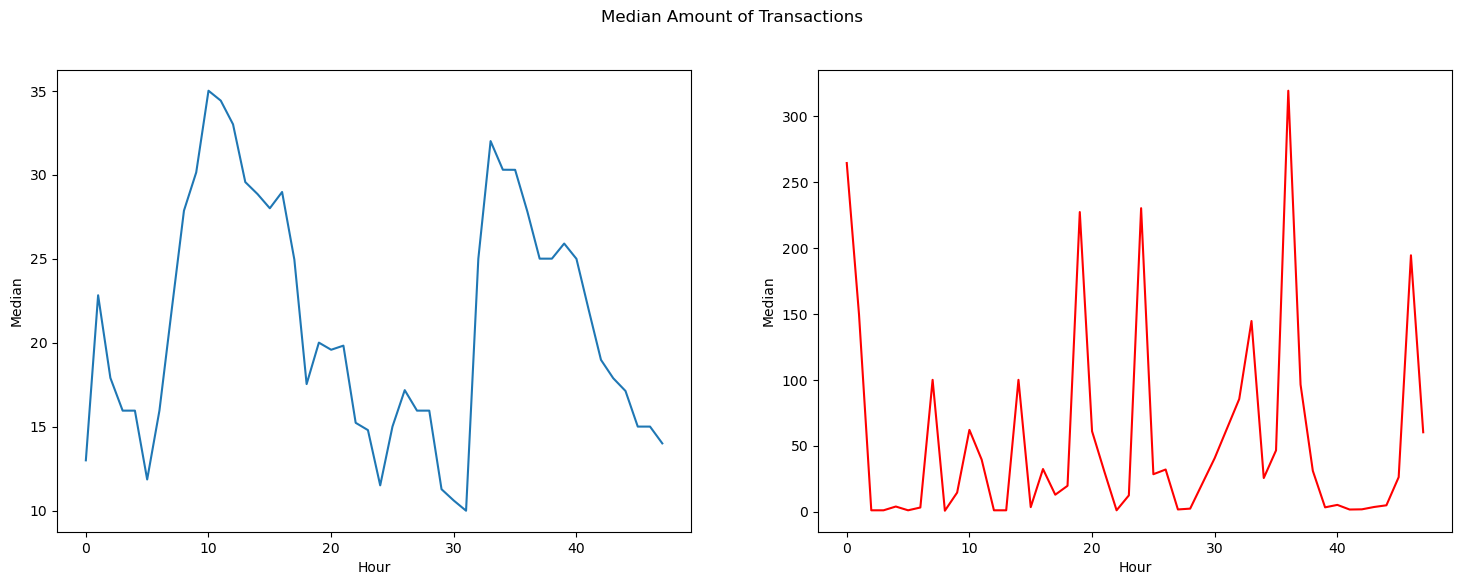

In [17]:
CustomPlot("Median Amount of Transactions", "Median")

### Minimum Amount of Transactions

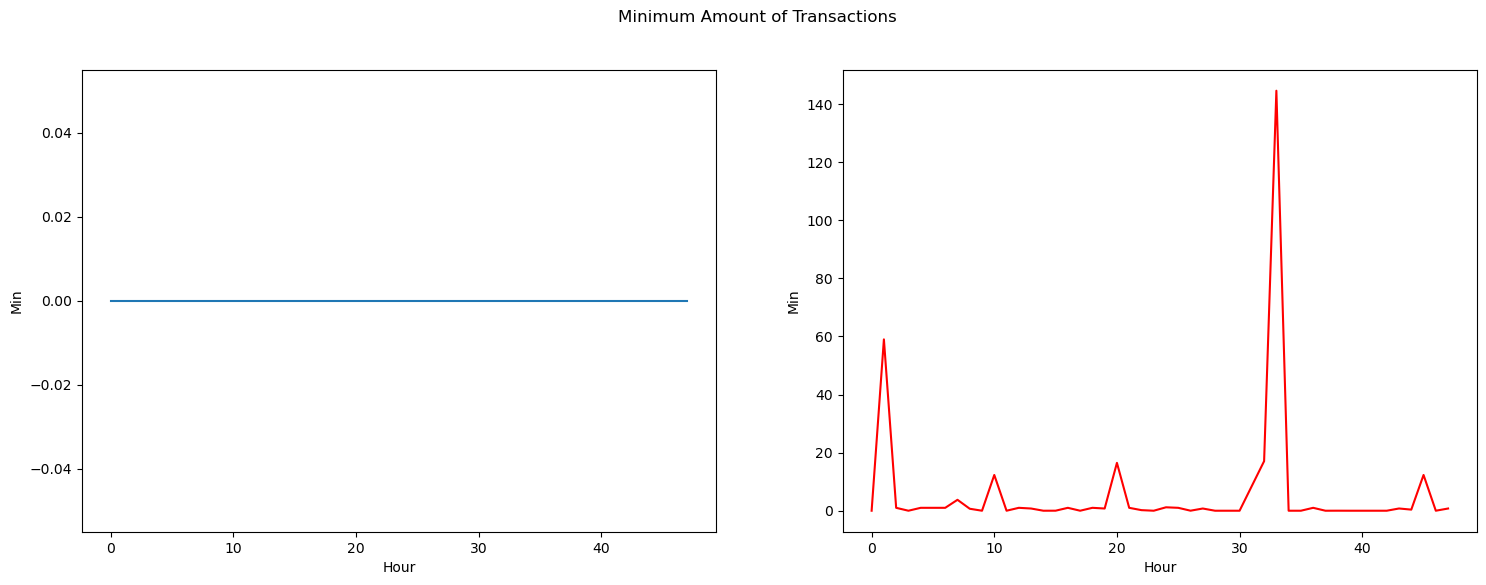

In [18]:
CustomPlot("Minimum Amount of Transactions", "Min")

## Transactions amount

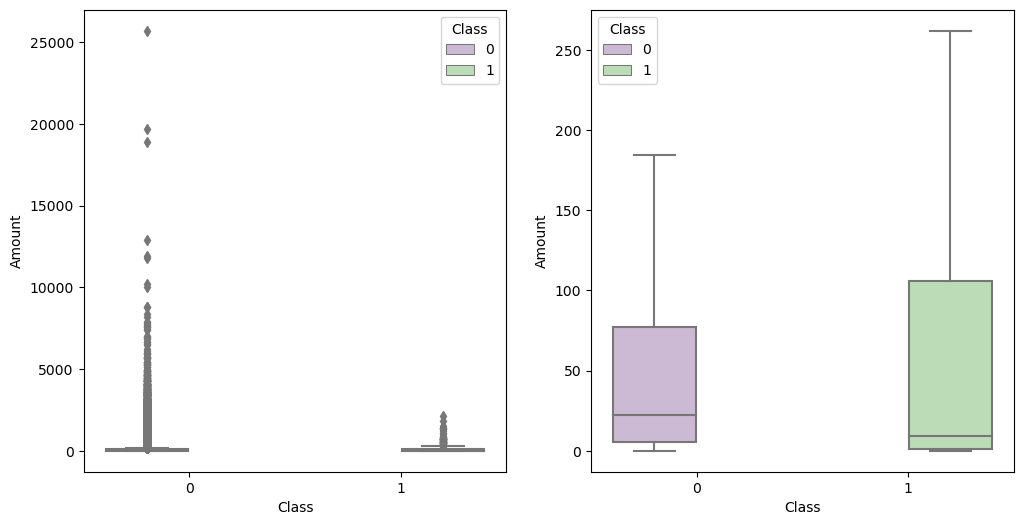

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [20]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount'] # Amount of non fraud
class_1 = tmp.loc[tmp['Class'] == 1]['Amount'] # Amount of fraud
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [21]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [22]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## <a id='5.2'>Features correlation</a>

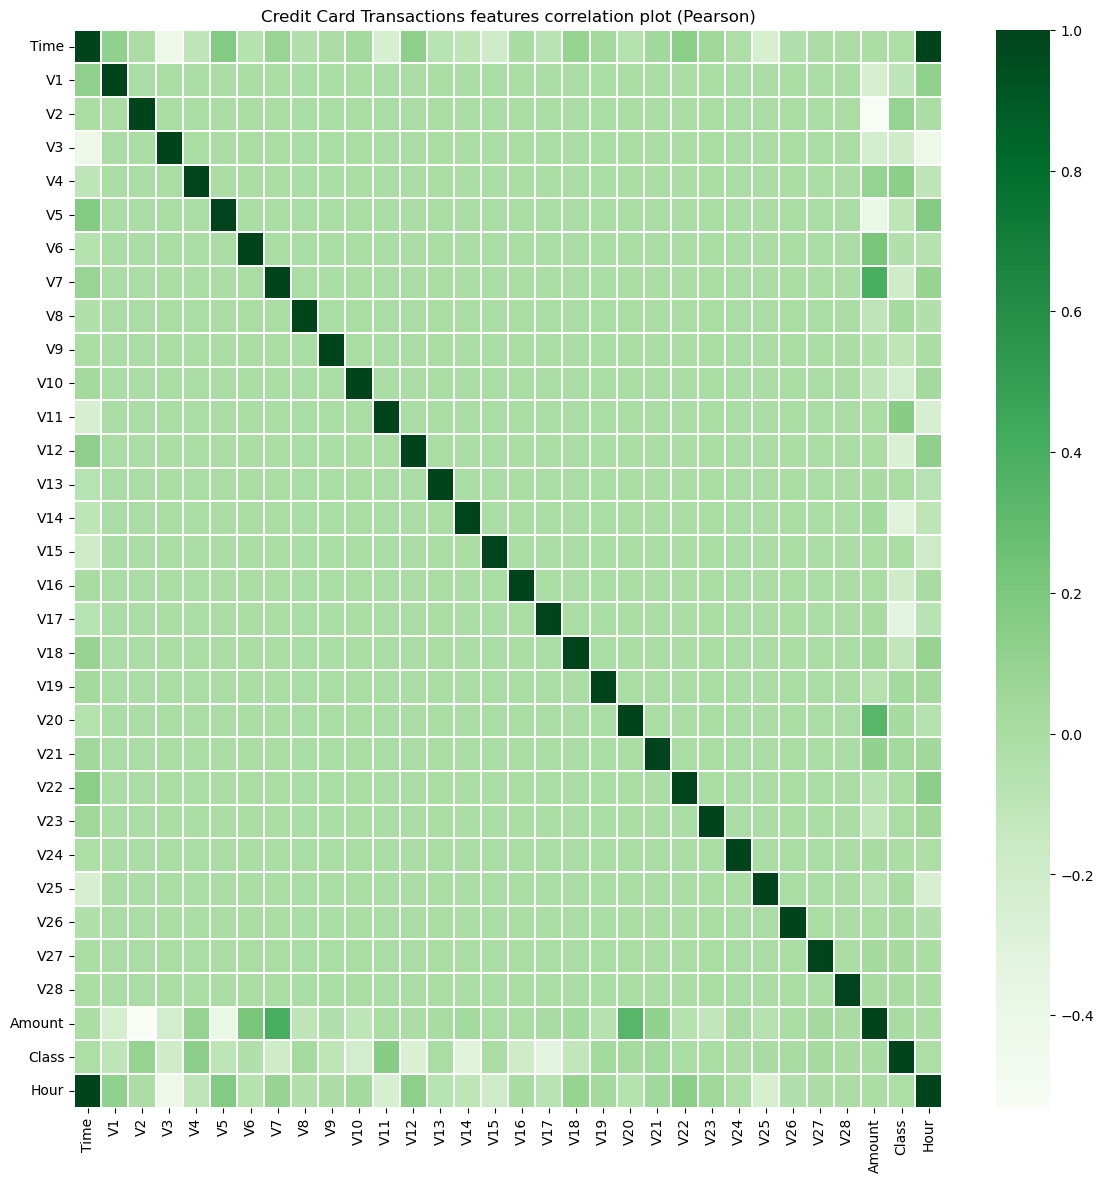

In [23]:
# Ploting heatmap for viewing correlation
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Greens")
plt.show()

As expected, there is no notable correlation between features **V1**-**V28**. There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V2** and **V5**).


Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

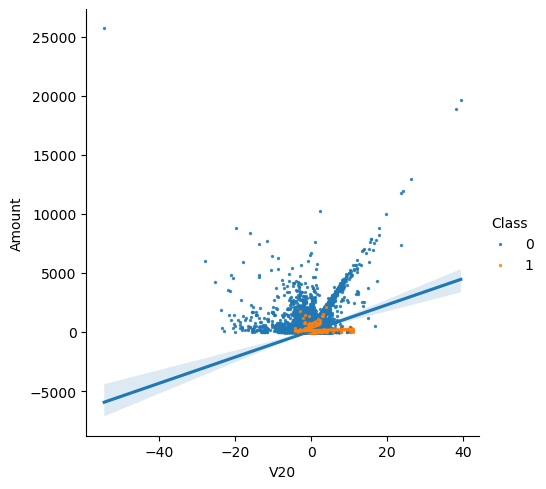

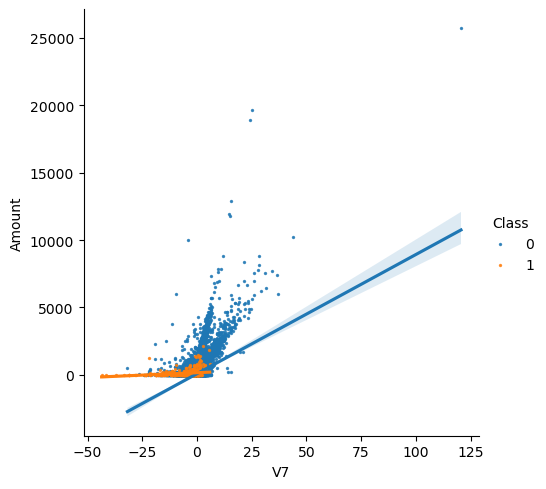

In [24]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).

Let's plot now the inverse correlated values.

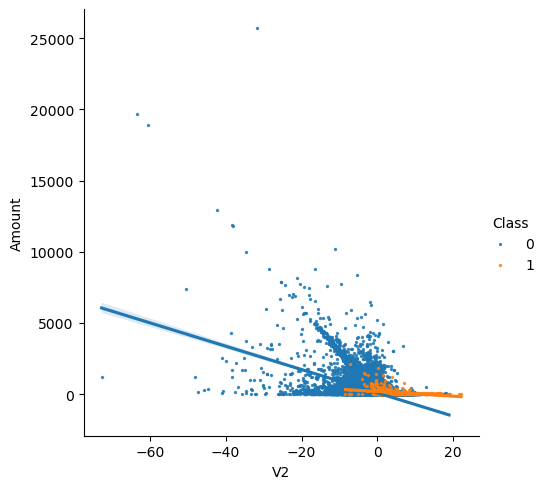

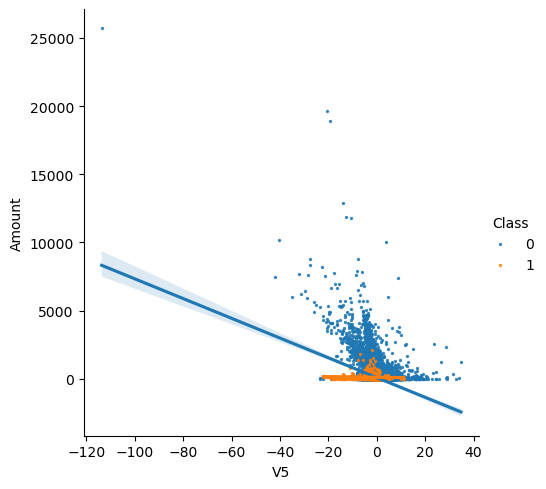

In [25]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).


## <a id='5.3'>Features density plot</a>

<Figure size 640x480 with 0 Axes>

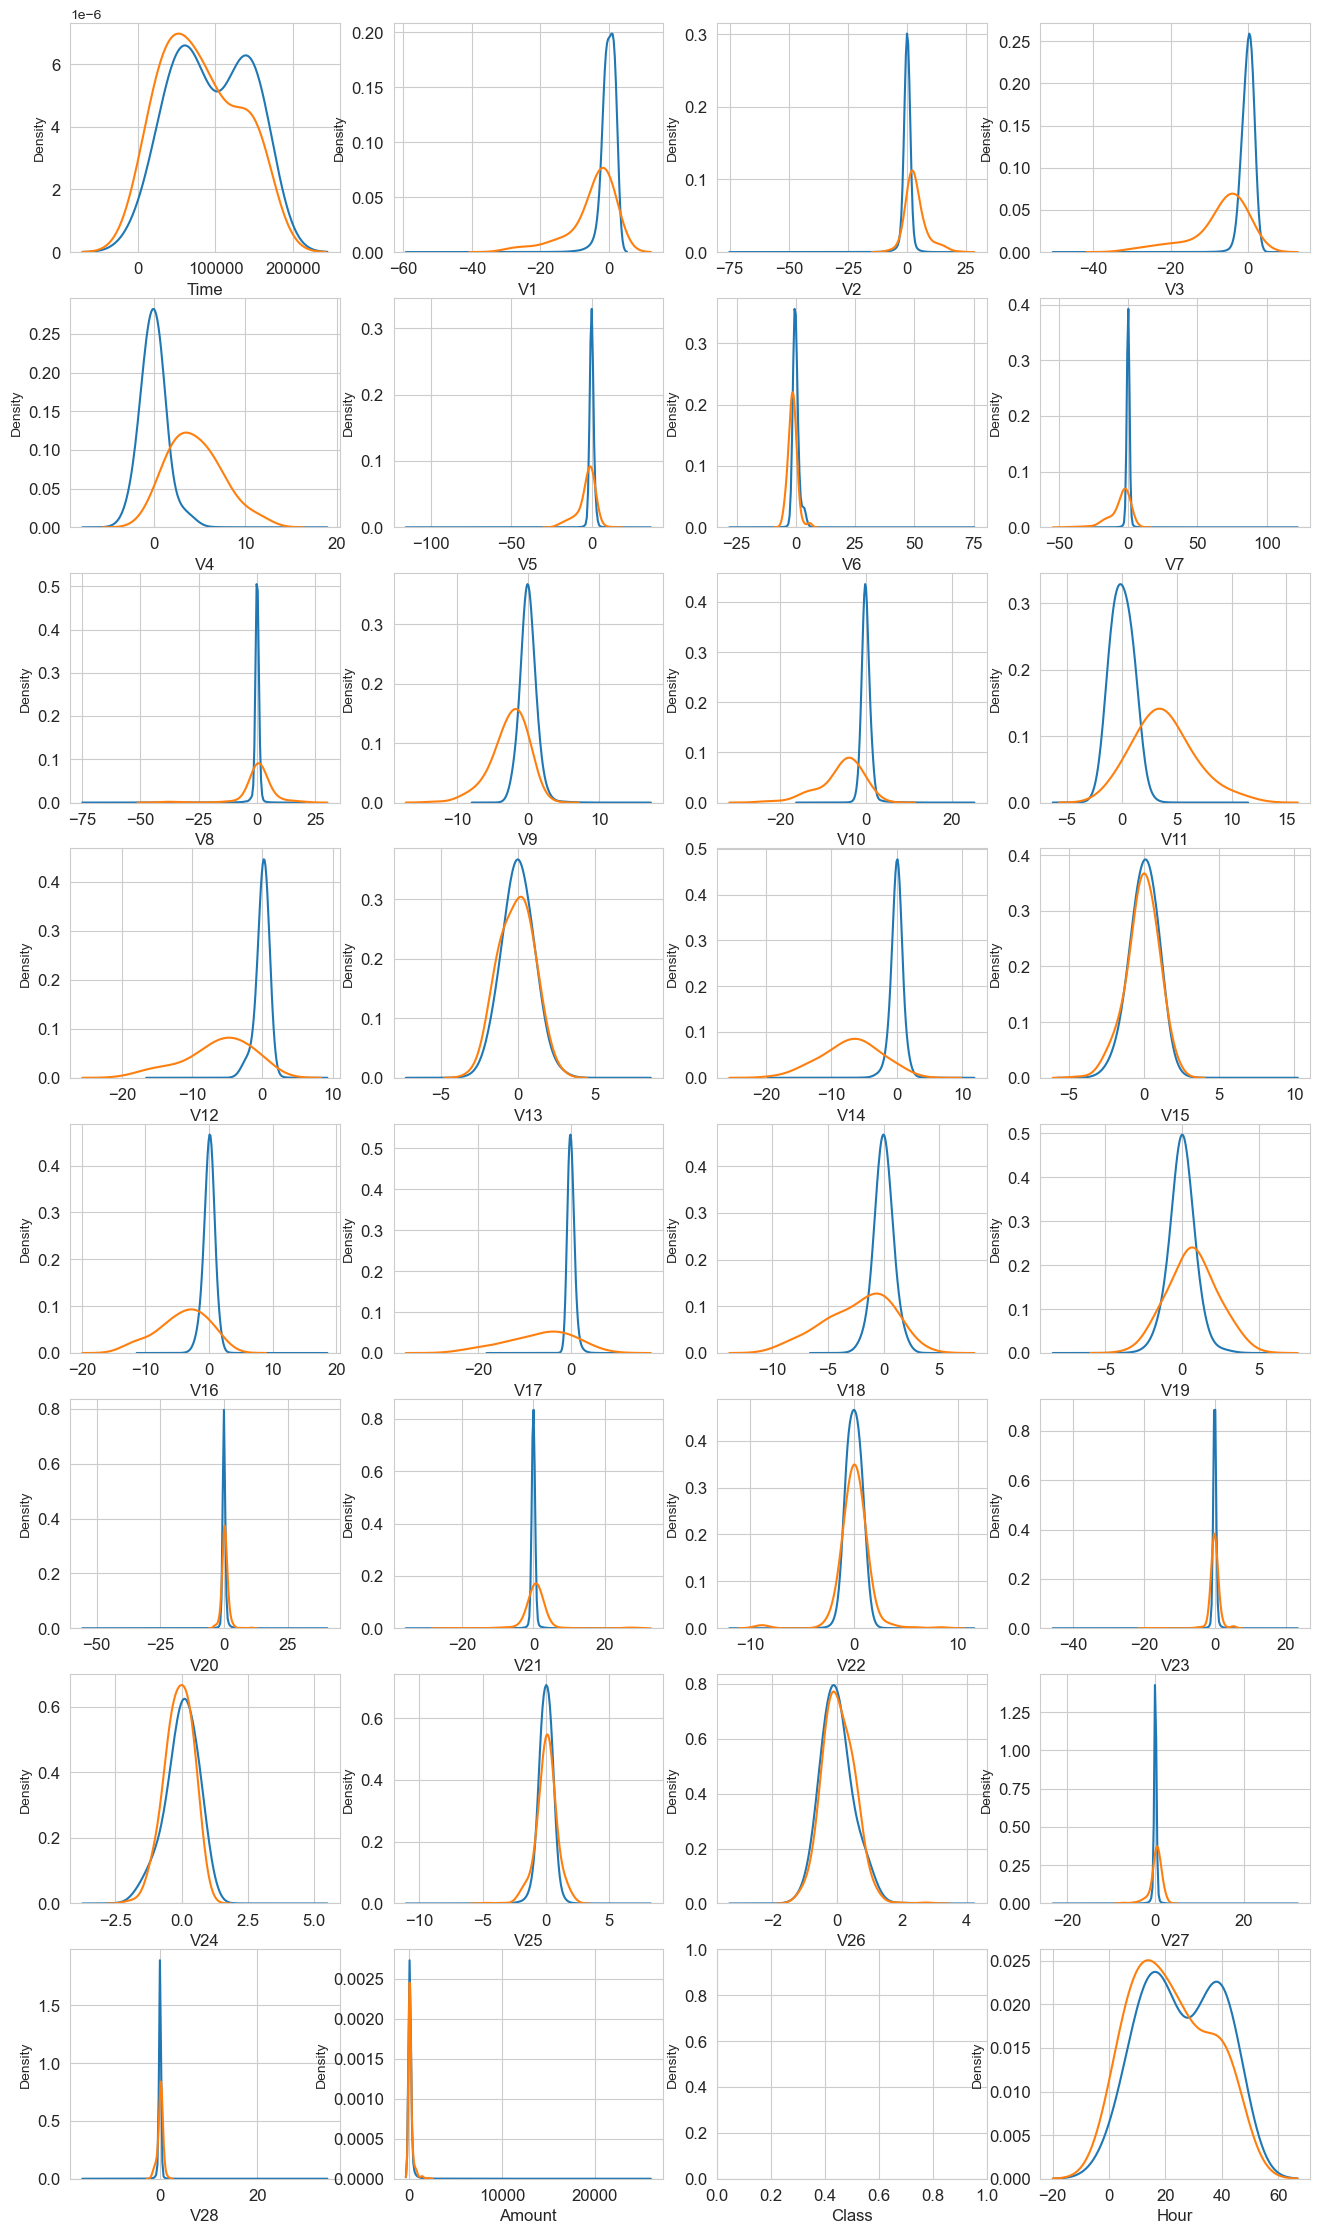

In [26]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw_method=0.5,label="Class = 0",warn_singular=False)
    sns.kdeplot(t1[feature], bw_method=0.5,label="Class = 1",warn_singular=False)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of **Class**: **V4**, **V11** have clearly separated distributions for **Class** values 0 and 1, **V12**, **V14**, **V18** are partially separated, **V1**, **V2**, **V3**, **V10** have a quite distinct profile, whilst **V25**, **V26**, **V28** have similar profiles for the two values of **Class**.  

In general, with just few exceptions (**Time** and **Amount**), the features distribution for legitimate transactions (values of **Class = 0**)  is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **Class = 1**) have a skewed (asymmetric) distribution.

# <a id='6'>Model Selection</a>
In this section we will building 3 models and test their performance so that we can select a model to build our application

## <a id='6.1'>Metrics</a>

### Type I error and Type II error

We need to clarify that confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data, because we will actually need a different metrics that accounts in the same time for the **selectivity** and **specificity** of the method we are using, so that we minimize in the same time both **Type I errors** and **Type II errors**.


**Null Hypothesis** (**H0**) - The transaction is not a fraud.  
**Alternative Hypothesis** (**H1**) - The transaction is a fraud.  

**Type I error** - You reject the null hypothesis when the null hypothesis is actually true.  
**Type II error** - You fail to reject the null hypothesis when the the alternative hypothesis is true.  

**Cost of Type I error** - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.  
**Cost of Type II error** - You erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted.  

The following image explains what **Type I error** and **Type II error** are:    


<img src="https://i.stack.imgur.com/x1GQ1.png" width="600"/>


So we are using ROC-AUC score along confusion matrix

In [27]:
# Defining a simple function for printing the result
def print_results(headline, true_value, pred):
    print(headline)
    print("roc auc score:{}".format(roc_auc_score(true_value, pred)))
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

def resultArray(headline, true_value, pred):
    re = np.array([[headline, round(roc_auc_score(true_value, pred),3), 
                   round(accuracy_score(true_value, pred),3),
                   round(precision_score(true_value, pred),3),
                   round(recall_score(true_value, pred),3),
                   round(fbeta_score(true_value, pred, beta=2),3)
                  ]])
    return re
    

### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [28]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

## <a id='6.2'>Normal data </a> 

### Split data in train, test and validation set

Let's define train, validation and test sets.

In [29]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )

## <a id='6.3'>UnderSampled data </a> 
We will create a new dataset which has same number of fraud and non fraud transaction by undersampling

In [30]:
nonfraud = data_df.loc[data_df['Class'] == 0] # Contains legit transactions
fraud = data_df.loc[data_df['Class'] == 1] # Contains non legit transactions


In [31]:
nonfraud = nonfraud.sample(n=492) # undersampling i.e cutting the legit transaction

sampled_df = pd.concat([nonfraud, fraud], axis=0)
sampled_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
227778,145217.0,-0.034099,0.618636,0.294326,-0.659922,0.253100,-0.816330,0.756994,0.085229,0.023092,-0.189506,0.519655,-0.305325,-2.308435,0.761962,-0.818432,0.124882,-0.445848,-0.094829,0.115581,-0.162415,-0.218363,-0.602504,0.117263,-0.050423,-0.617706,0.127974,0.229640,0.083467,8.98,0,40.0
110297,71761.0,-1.703882,1.373495,1.566025,2.907264,-1.849697,1.975086,-0.224770,1.481039,-0.692024,0.416020,-0.079033,-0.442361,-2.187225,0.661766,-0.310838,-0.009255,0.804142,0.441480,1.219951,0.065503,-0.112594,-0.236923,0.080860,-0.369747,0.077218,0.264442,0.308336,0.024587,209.44,0,19.0
28325,34954.0,-0.897864,0.281932,-0.087297,-2.815038,2.469784,3.558050,0.995604,-0.234710,2.293080,0.361382,-0.122957,0.014898,-0.401275,-1.195914,0.408445,-1.433230,-0.730018,0.220882,1.529059,0.270112,-0.228748,0.418393,-0.353860,1.040643,0.019318,-0.929175,-1.425230,-1.163436,50.00,0,9.0
243585,151988.0,-1.035157,0.893658,2.311512,-0.518355,-0.862442,-0.469055,-0.155518,0.459066,0.010065,-1.351117,-0.491224,1.006083,1.472376,-0.285847,0.716219,0.124947,-0.193414,0.124159,0.137768,0.001234,0.151727,0.438308,-0.249832,0.514818,0.285725,0.098588,-0.042315,0.010924,9.99,0,42.0
196133,131370.0,2.290149,-1.404003,-1.162591,-1.798887,-0.852818,-0.103816,-1.121415,-0.115990,-1.472956,1.707158,-0.080214,0.015584,1.307678,-0.465218,-0.896152,-0.105056,-0.163694,0.597650,0.520546,-0.317954,-0.190866,-0.047684,0.100875,-1.037859,-0.112202,-0.162145,0.012777,-0.064216,30.85,0,36.0


In [32]:
sampled_df['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

This new df is not unbalanced

In [33]:
sampled_train_df, sampled_test_df = train_test_split(sampled_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )

**We will test our models with both normal and undersampled data**

Let's start with a RandomForrestClassifier model <a href='#11'>[2]</a>.

## <a id='6.4'>RandomForrestClassifier</a>
### Define model parameters

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation. 

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** <a href='#11'>[3]</a>. Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

### <a id='6.4a'>Prepare the model for Normal data</a>  

In [34]:
normal_rfc = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [35]:
normal_rfc.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2024, verbose=False)

In [36]:
normal_rfc_preds = normal_rfc.predict(test_df[predictors])

### Features importance

Let's see also the features importance.

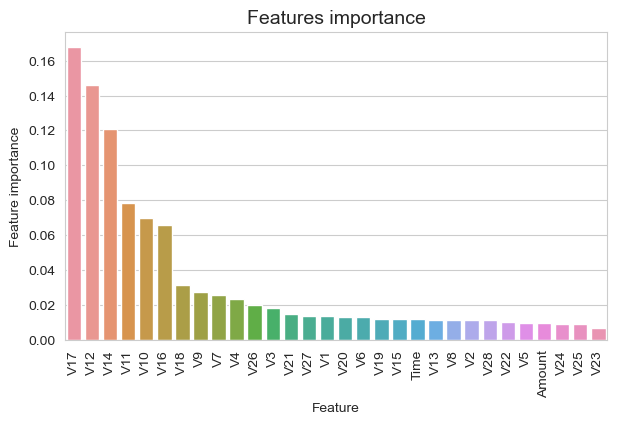

In [37]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': normal_rfc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The most important features are **V17**, **V12**, **V14**, **V16**, **V11**, **V10**.
### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

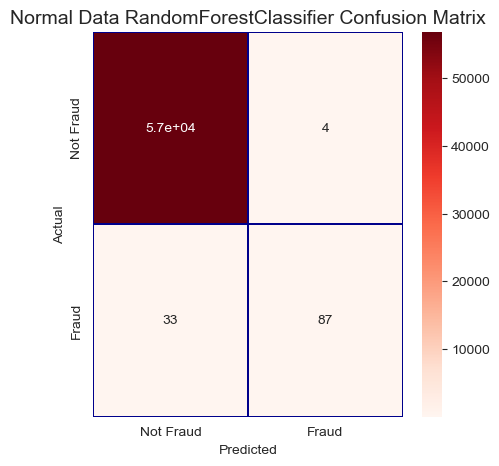

In [38]:
cm = pd.crosstab(test_df[target].values, normal_rfc_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Reds")
plt.title('Normal Data RandomForestClassifier Confusion Matrix', fontsize=14)
plt.show()

### Result

In [39]:
print_results("normal_rfc",test_df[target].values, normal_rfc_preds)
resultRF = resultArray("normal_rfc",test_df[target].values, normal_rfc_preds)

result_df = pd.DataFrame(resultRF, columns=["Model name","roc auc","accuracy", "precision","recall","f2"])

normal_rfc
roc auc score:0.862464814749657
accuracy: 0.9993504441557529
precision: 0.9560439560439561
recall: 0.725
f2: 0.7618213660245184


### <a id='6.4b'>Prepare the model for UnderSampled data</a> 

In [40]:
sampled_rfc = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [41]:
sampled_rfc.fit(sampled_train_df[predictors], sampled_train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2024, verbose=False)

In [42]:
sampled_rfc_preds = sampled_rfc.predict(sampled_test_df[predictors])

### Features importance

Let's see also the features importance.

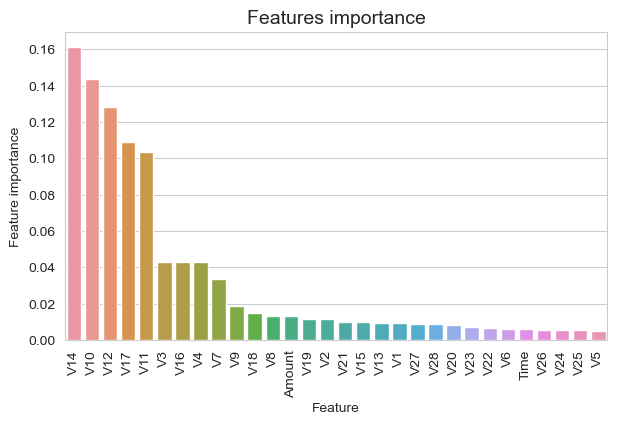

In [43]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': sampled_rfc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

From sampled dataset we are getting different important features and they are **V14**, **V12**, **V4**, **V10**, **V11**,  **V17**, **V16**.
### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

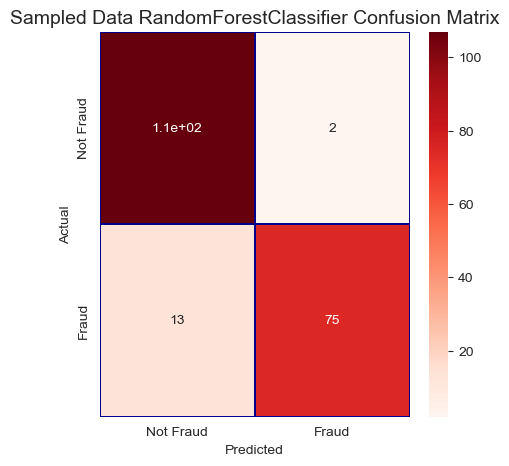

In [44]:
cm = pd.crosstab(sampled_test_df[target].values, sampled_rfc_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Reds")
plt.title('Sampled Data RandomForestClassifier Confusion Matrix', fontsize=14)
plt.show()

### Results

In [45]:
print_results("sampled_rfc",sampled_test_df[target].values, sampled_rfc_preds)

sampled_rfc
roc auc score:0.9169620517097581
accuracy: 0.9238578680203046
precision: 0.974025974025974
recall: 0.8522727272727273
f2: 0.8741258741258742


In [46]:
result = resultArray("sampled_rfc",sampled_test_df[target].values, sampled_rfc_preds)

result_df.loc[len(result_df)] = result[0]

## <a id='6.5'>AdaBoostClassifier</a> 
AdaBoostClassifier stands for Adaptive Boosting Classifier

### <a id='6.5a'>Prepare the model for Normal data</a>

Let's set the parameters for the model and initialize the model <a href='#11'>[4]</a>.

In [47]:
normal_clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [48]:
normal_clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2024)

### Predict the target values

Let's now predict the **target** values for the **test_df** data, using predict function.

In [49]:
normal_clf_preds = normal_clf.predict(test_df[predictors])

### Features importance

Let's see also the features importance.

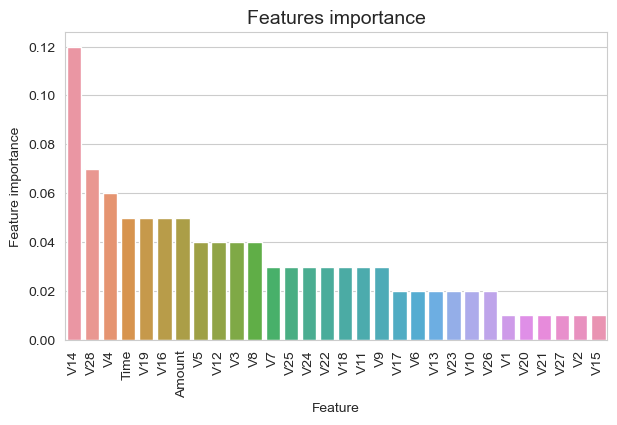

In [50]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': normal_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

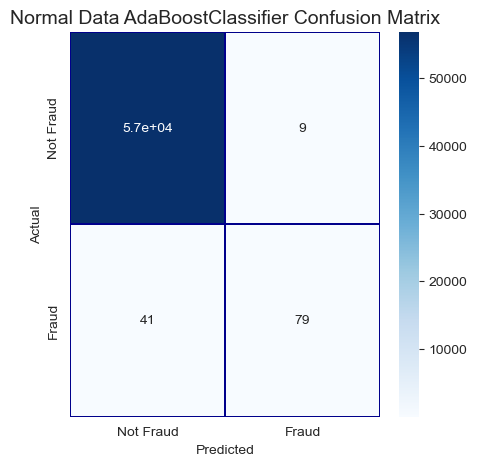

In [51]:
cm = pd.crosstab(test_df[target].values, normal_clf_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Normal Data AdaBoostClassifier Confusion Matrix', fontsize=14)
plt.show()

Let's see the results.


### Results

In [52]:
print_results("AdaBoostClassifier with normal data",test_df[target].values, normal_clf_preds)

AdaBoostClassifier with normal data
roc auc score:0.8290874998533947
accuracy: 0.9991222218320986
precision: 0.8977272727272727
recall: 0.6583333333333333
f2: 0.6954225352112676


In [53]:
result = resultArray("AdaBoostClassifier with normal data",test_df[target].values, normal_clf_preds)

result_df.loc[len(result_df)] = result[0]

### <a id='6.5b'>Prepare the model for UnderSampled data</a> 

In [54]:
sampled_clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [55]:
sampled_clf.fit(sampled_train_df[predictors], sampled_train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2024)

In [56]:
sampled_clf_preds = sampled_clf.predict(sampled_test_df[predictors])

### Features importance

Let's see also the features importance.

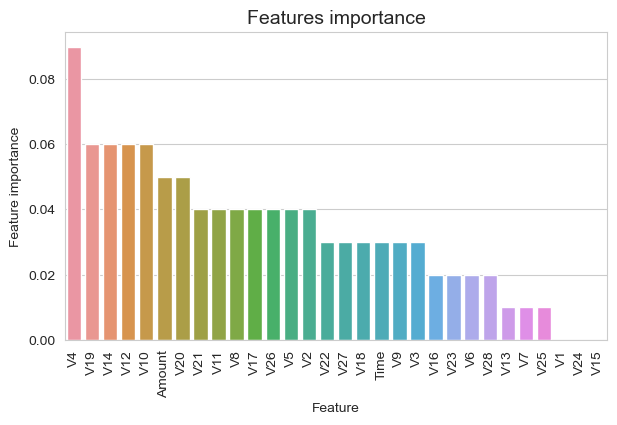

In [57]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': sampled_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

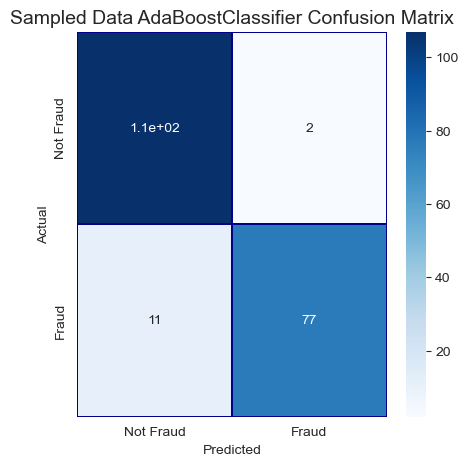

In [58]:
cm = pd.crosstab(sampled_test_df[target].values, sampled_clf_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Sampled Data AdaBoostClassifier Confusion Matrix', fontsize=14)
plt.show()

Let's see the results.


### Results

In [59]:
print_results("AdaBoostClassifier with sampled data",sampled_test_df[target].values, sampled_clf_preds)

AdaBoostClassifier with sampled data
roc auc score:0.9283256880733944
accuracy: 0.934010152284264
precision: 0.9746835443037974
recall: 0.875
f2: 0.8932714617169374


In [60]:
result = resultArray("AdaBoostClassifier with sampled data",sampled_test_df[target].values, sampled_clf_preds)

result_df.loc[len(result_df)] = result[0]

## <a id='6.6'>CatBoostClassifier</a> 
CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data <a href='#11'>[5]</a>.

### <a id='6.6a'>Prepare the model for Normal data</a> 

Let's set the parameters for the model and initialize the model.

In [61]:
normal_cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [62]:
normal_cbc.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 698ms	remaining: 5m 48s
50:	total: 30s	remaining: 4m 24s
100:	total: 58.6s	remaining: 3m 51s
150:	total: 1m 43s	remaining: 4m
200:	total: 2m 37s	remaining: 3m 54s
250:	total: 3m 28s	remaining: 3m 27s
300:	total: 4m 53s	remaining: 3m 13s
350:	total: 5m 35s	remaining: 2m 22s
400:	total: 6m 7s	remaining: 1m 30s
450:	total: 6m 36s	remaining: 43s
499:	total: 7m 9s	remaining: 0us


### Predict the target values

Let's now predict the **target** values for the **test_df** data, using predict function.

In [63]:
normal_cbc_preds = normal_cbc.predict(test_df[predictors])

### Features importance

Let's see also the features importance.

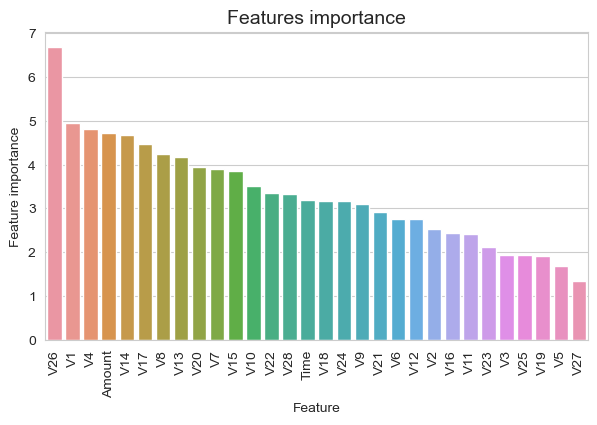

In [64]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': normal_cbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

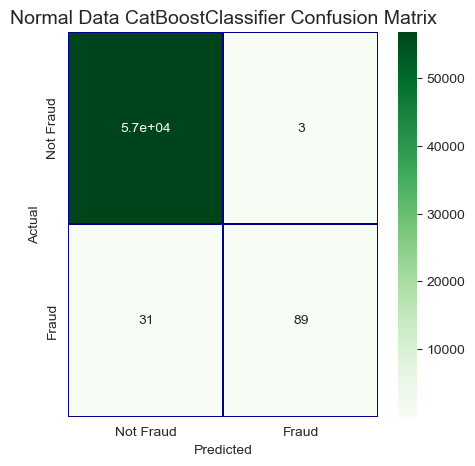

In [65]:
cm = pd.crosstab(test_df[target].values, normal_cbc_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Greens")
plt.title('Normal Data CatBoostClassifier Confusion Matrix', fontsize=14)
plt.show()

Let's see the results.


### Results

In [66]:
print_results("CatBoostClassifier with normal data",test_df[target].values, normal_cbc_preds)

CatBoostClassifier with normal data
roc auc score:0.8708069443955759
accuracy: 0.999403110845827
precision: 0.967391304347826
recall: 0.7416666666666667
f2: 0.777972027972028


In [67]:
result = resultArray("CatBoostClassifier with normal data",test_df[target].values, normal_cbc_preds)

result_df.loc[len(result_df)] = result[0]

### <a id='6.6b'>Prepare the model for UnderSampled data</a>

In [68]:
sampled_cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [69]:
sampled_cbc.fit(sampled_train_df[predictors], sampled_train_df[target].values,verbose=True)

0:	total: 400ms	remaining: 3m 19s
50:	total: 20.5s	remaining: 3m
100:	total: 39.1s	remaining: 2m 34s
150:	total: 59.6s	remaining: 2m 17s
200:	total: 1m 20s	remaining: 2m
250:	total: 1m 41s	remaining: 1m 40s
300:	total: 2m	remaining: 1m 19s
350:	total: 2m 19s	remaining: 59.4s
400:	total: 2m 40s	remaining: 39.7s
450:	total: 3m 34s	remaining: 23.4s
499:	total: 4m 31s	remaining: 0us


In [70]:
sampled_cbc_preds = sampled_cbc.predict(sampled_test_df[predictors])

### Features importance

Let's see also the features importance.

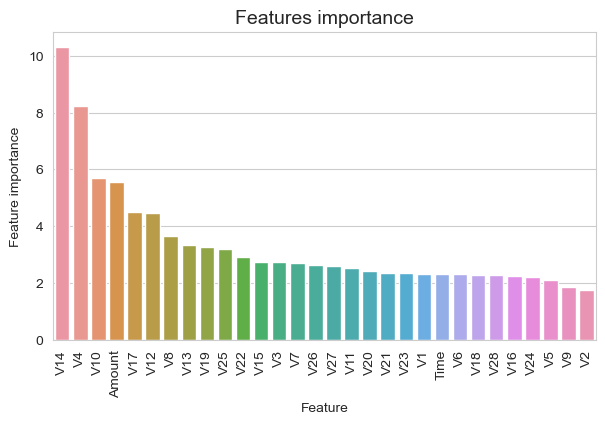

In [71]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': sampled_cbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

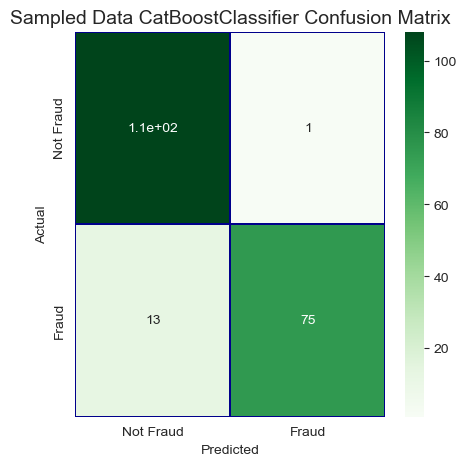

In [72]:
cm = pd.crosstab(sampled_test_df[target].values, sampled_cbc_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Greens")
plt.title('Sampled Data CatBoostClassifier Confusion Matrix', fontsize=14)
plt.show()

Let's see the result
### Results

In [73]:
print_results("CatBoostClassifier with sampled data",sampled_test_df[target].values, sampled_cbc_preds)

CatBoostClassifier with sampled data
roc auc score:0.9215492076730609
accuracy: 0.9289340101522843
precision: 0.9868421052631579
recall: 0.8522727272727273
f2: 0.8761682242990654


In [74]:
result = resultArray("CatBoostClassifier with sampled data",sampled_test_df[target].values, sampled_cbc_preds)
result_df.loc[len(result_df)] = result[0]

# <a id='7'>Viewing the final result</a>

In [75]:
result_df

,Model name,roc auc,accuracy,precision,recall,f2
0,normal_rfc,0.862,0.999,0.956,0.725,0.762
1,sampled_rfc,0.917,0.924,0.974,0.852,0.874
2,AdaBoostClassifier with normal data,0.829,0.999,0.898,0.658,0.695
3,AdaBoostClassifier with sampled data,0.928,0.934,0.975,0.875,0.893
4,CatBoostClassifier with normal data,0.871,0.999,0.967,0.742,0.778
5,CatBoostClassifier with sampled data,0.922,0.929,0.987,0.852,0.876


# <a id='8'>Model Summary</a>

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. 

We have used 3 models
 - **RandomForrestClassifier**
 - **AdaBoostClassifier**
 - **CatBoostClassifier**
    
Each model is trained with 2 kinds of data
 - **Normal data** - Imbalanced data(Original data)
 - **Sampled data** - Undersampled data
    
From the DataFrame **result_df** we can see that each model is performed better with the sampled data.

So we will be choosing our model which used sampled data based on **roc auc score** and **f2 score** since these 2 metric are most important.

Based on the 2 metric we can see that **RandomForrestClassifier** has performed good with roc auc score of **0.899** and f2 score of **0.873**

SO for creating our api we will be using RandomForrestClassifier with sampled data

# <a id='9'>Creating a pickle file</a>
For creating a api we need a pre trained model.

So we will be training a model and load it as a pickel file

There are 30 features available and will be not good if have to get these 30 features as inputs from the user

So we will be creating our new model based on the important features only

In [76]:
final_features = ['V4', 'V10', 'V11', 'V12', 'V14', 'V16',
                  'V17', 'Amount'  ]
sampled_train_df[final_features]

,V4,V10,V11,V12,V14,V16,V17,Amount
54062,1.047484,-0.775502,-0.752114,0.503812,1.219456,0.217514,0.275388,197.45
143133,1.392668,-0.561391,-1.013797,-0.500586,0.659648,-1.018686,0.907215,37.57
272483,1.073174,0.351142,-0.746689,-0.453869,0.459212,-1.269586,0.763471,0.99
272260,0.631261,0.617558,0.229745,-0.509968,0.588149,1.585490,-1.214365,133.05
110297,2.907264,0.416020,-0.079033,-0.442361,0.661766,-0.009255,0.804142,209.44
...,...,...,...,...,...,...,...,...
10897,11.165526,-14.166795,10.277769,-14.985434,-14.666389,-8.333242,-12.602596,1.00
50211,3.880960,-5.726817,3.525726,-6.489112,-7.052311,-6.773977,-8.588070,1.00
42635,8.174825,-11.519861,6.455828,-13.380222,-13.026864,-13.251542,-22.883999,11.38
6641,7.380245,-3.944238,6.355078,-7.309748,-9.057993,-1.073117,1.524501,1.00


In [77]:
Finalmodel = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [78]:
Finalmodel.fit(sampled_train_df[final_features], sampled_train_df[target].values)


RandomForestClassifier(n_jobs=4, random_state=2024, verbose=False)

In [79]:
pickle.dump(Finalmodel, open('model.pkl','wb')) # Dumping our model into pkl

In [80]:
# Loading and predicting using the pkl file
model = pickle.load(open('model.pkl','rb'))
preds = model.predict(sampled_test_df[final_features])

In [81]:
print_results("model",sampled_test_df[target].values, preds)

model
roc auc score:0.9226438698915763
accuracy: 0.9289340101522843
precision: 0.9743589743589743
recall: 0.8636363636363636
f2: 0.8837209302325582


Even with 8 features our model is performing good!!!.

# <a id="10">Conclusion</a>

Using the model.pkl file we have created a API using using flask(app.py) and also tested the endpoints in postman.

### Application deployed in local server

<center><img src="../inputs/Application.png" width="600"></img></center>

### Application endpoints tested using Postman

<center><img src="../inputs/EndpointTesting.png" width="600"></img></center>

# <a id="11">References</a>

[1] Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis  
[2] RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[3] ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
[4] AdaBoostClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
[5] CatBoostClassifier, https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/